Modelo      MAE     RMSE     MAPE%
   DES 0.278263 0.338379 64.665045
   TES 0.298472 0.359598 66.735319
   SES 0.370458 0.443351 76.278450
Mejor modelo (RMSE): DES


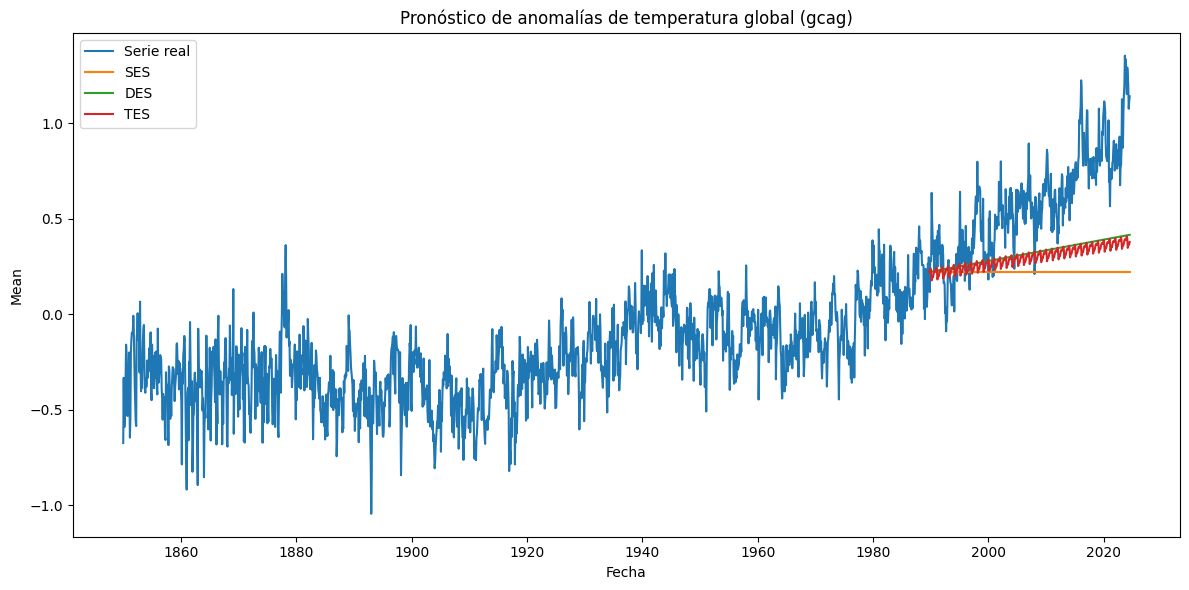

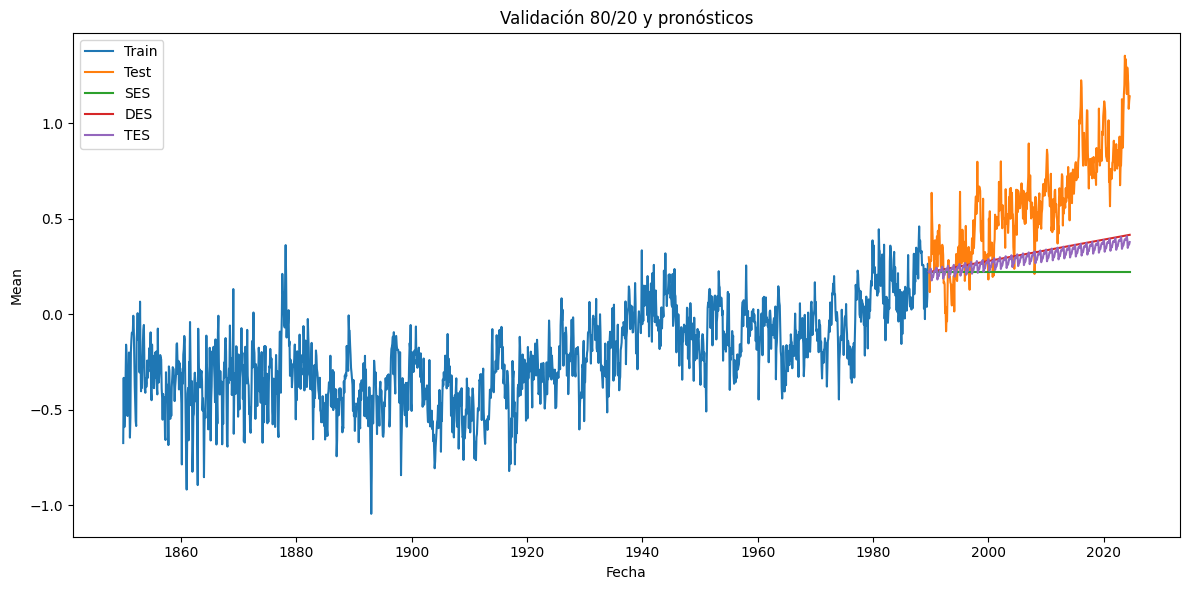

In [1]:
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

try:
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "statsmodels"])
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing


# =========================
# Carga
# =========================
url = "https://raw.githubusercontent.com/datasets/global-temp/main/data/monthly.csv"
df = pd.read_csv(url)

df = df[df["Source"] == "gcag"].copy()
df["Date"] = pd.to_datetime(df["Year"].astype(str), errors="raise")
df = df.set_index("Date").sort_index()

df = df.asfreq("MS")

serie = df["Mean"].astype(float)


# =========================
# Valores faltantes
# =========================
if serie.isna().any():
    serie = serie.interpolate(method="linear")


# =========================
# Train / Test (80/20)
# =========================
train_size = int(len(serie) * 0.8)
train = serie.iloc[:train_size]
test  = serie.iloc[train_size:]


# =========================
# Modelos SES / DES / TES
# =========================
ses = SimpleExpSmoothing(train).fit(optimized=True)
pred_ses = ses.forecast(len(test))

des = ExponentialSmoothing(train, trend="add", seasonal=None).fit(optimized=True)
pred_des = des.forecast(len(test))

tes = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).fit(optimized=True)
pred_tes = tes.forecast(len(test))


# =========================
# Métricas
# =========================
def metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    y_true_np = np.asarray(y_true)
    y_pred_np = np.asarray(y_pred)
    denom = np.where(np.abs(y_true_np) < 1e-8, np.nan, np.abs(y_true_np))
    mape = np.nanmean(np.abs((y_true_np - y_pred_np) / denom)) * 100
    return mae, rmse, mape

mae_ses, rmse_ses, mape_ses = metricas(test, pred_ses)
mae_des, rmse_des, mape_des = metricas(test, pred_des)
mae_tes, rmse_tes, mape_tes = metricas(test, pred_tes)

resultados = (
    pd.DataFrame({
        "Modelo": ["SES", "DES", "TES"],
        "MAE":    [mae_ses, mae_des, mae_tes],
        "RMSE":   [rmse_ses, rmse_des, rmse_tes],
        "MAPE%":  [mape_ses, mape_des, mape_tes],
    })
    .sort_values("RMSE")
    .reset_index(drop=True)
)

print(resultados.to_string(index=False))
print("Mejor modelo (RMSE):", resultados.loc[0, "Modelo"])


# =========================
# Gráficas
# =========================
plt.figure(figsize=(12, 6))
plt.plot(serie.index, serie.values, label="Serie real")
plt.plot(test.index, pred_ses.values, label="SES")
plt.plot(test.index, pred_des.values, label="DES")
plt.plot(test.index, pred_tes.values, label="TES")
plt.title("Pronóstico de anomalías de temperatura global (gcag)")
plt.xlabel("Fecha")
plt.ylabel("Mean")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test")
plt.plot(test.index, pred_ses.values, label="SES")
plt.plot(test.index, pred_des.values, label="DES")
plt.plot(test.index, pred_tes.values, label="TES")
plt.title("Validación 80/20 y pronósticos")
plt.xlabel("Fecha")
plt.ylabel("Mean")
plt.legend()
plt.tight_layout()
plt.show()